# Guardian News Fetcher

In [1]:
import requests
import json 
import pandas as pd
import html2text
import tqdm.notebook as tqdm
import copy
import numpy as np
import matplotlib.pyplot as plt

GUARDIAN_API_KEY =  "6c15c612-076e-4fff-9023-194e033a4c85"

## Utility Functions

In [2]:
def print_json(results): 
    print(json.dumps(results, indent=2))

h = html2text.HTML2Text()
h.ignore_links = True

1. Get total number of pages of articles containing the words "coronavirus" and "covid-19"

In [3]:
search_query = 'coronavirus|covid-19'
from_date = '2019-12-25'
order_by = 'oldest'
page_size = '50'
fields = 'headline'
blocks = 'body'

fetch_url = f'https://content.guardianapis.com/search?q={search_query}&from-date={from_date}&order-by={order_by}&page-size={page_size}&show-fields={fields}&show-blocks={blocks}&api-key={GUARDIAN_API_KEY}'

r = requests.get(fetch_url).json()

number_of_pages = r['response']['pages']


2. Fetch every article from every page

In [4]:
content = {}

content_no = 0

for page in tqdm.tqdm(range(1, number_of_pages + 1)):
    fetch_url = f'https://content.guardianapis.com/search?q={search_query}&from-date={from_date}&order-by={order_by}&page-size={page_size}&show-fields={fields}&show-blocks={blocks}&page={page}&api-key={GUARDIAN_API_KEY}'
    r = requests.get(fetch_url).json()
   
    results = r['response']['results']   

    for result in tqdm.tqdm(results, leave=False):
        
        content[content_no] = {
            'id': result['id'],
            'section': result['sectionName'],
            'date_published': result['webPublicationDate'],
            'headline': result['fields']['headline'],
            'url': result['webUrl'],
            'body': h.handle(result['blocks']['body'][0]['bodyHtml'])
        }
        
        content_no += 1

print(f"Number of articles found: {len(content.keys())}")   


Number of articles found: 2930


3. Preprocess the data to remove any articles without the words "coronavirus" or "covid-19"

In [5]:
ids = list(content.keys())

for id in tqdm.tqdm(ids):
    entry = content[id]
    body = entry['body']
    body = body.split()
        
    no_coronavirus = "coronavirus" not in body
    no_covid19 = "covid-19" not in body
    no_COVID19 = "COVID-19" not in body
        
    if no_coronavirus and no_covid19 and no_COVID19:
        content.pop(id)

# Create final dict with correct article no
processed_content = {}
content_no = 0
        
for id in content.keys():
    processed_content[content_no] = content[id]
    content_no += 1

4. Save data as `json`

In [7]:
with open('news.json', 'w') as fp:
    json.dump(processed_content, fp)

## Visualisations

In [28]:
df = pd.DataFrame(processed_content)

df = df.T
df

df['section'].unique()
df.loc[df['section'] == 'Society']

,id,section,date_published,headline,url,body
4,society/2020/jan/18/expert-questions-effective...,Society,2020-01-18T19:20:36Z,Expert questions effectiveness of coronavirus ...,https://www.theguardian.com/society/2020/jan/1...,\n\nMedical staff at airports trying to screen...
100,society/2020/jan/29/uk-supermarkets-move-to-cu...,Society,2020-01-29T06:00:39Z,UK supermarkets move to cut antibiotic use in ...,https://www.theguardian.com/society/2020/jan/2...,\n\nMost of the UK’s leading supermarket chain...
109,society/2020/jan/29/boris-johnsons-chinese-hos...,Society,2020-01-29T18:14:54Z,Boris Johnson’s Chinese hospital challenge,https://www.theguardian.com/society/2020/jan/2...,\n\nIn response to the country’s coronavirus o...
472,society/2020/feb/18/gps-overstretched-planning...,Society,2020-02-18T12:00:26Z,GPs are already overstretched. We need better ...,https://www.theguardian.com/society/2020/feb/1...,\n\nIt is 8am and amid the morning rush of cal...
675,society/2020/feb/27/coronavirus-england-only-h...,Society,2020-02-27T18:07:29Z,Coronavirus: England only has 15 beds for wors...,https://www.theguardian.com/society/2020/feb/2...,\n\nEngland only has 15 available beds for adu...
823,society/2020/mar/02/coronavirus-just-eight-out...,Society,2020-03-02T15:22:52Z,"Coronavirus: just eight out of 1,600 doctors i...",https://www.theguardian.com/society/2020/mar/0...,\n\nAn overwhelming majority of doctors fear t...
879,society/2020/mar/03/coronavirus-care-workers-i...,Society,2020-03-03T12:00:11Z,We crumblies are less afraid of the coronaviru...,https://www.theguardian.com/society/2020/mar/0...,"\n\n“If someone’s going to make my breakfast, ..."
963,society/2020/mar/04/prof-chris-whitty-the-expe...,Society,2020-03-04T18:15:20Z,Prof Chris Whitty: the expert we need in the c...,https://www.theguardian.com/society/2020/mar/0...,"\n\nTo the broader public, Prof Chris Whitty, ..."
970,society/2020/mar/04/care-workers-could-be-rede...,Society,2020-03-04T19:19:53Z,Care workers could be redeployed to UK coronav...,https://www.theguardian.com/society/2020/mar/0...,\n\nCare workers could be redeployed to look a...
1215,society/shortcuts/2020/mar/09/how-to-keep-your...,Society,2020-03-09T13:19:19Z,How to keep your hands clean – without getting...,https://www.theguardian.com/society/shortcuts/...,"\n\nDue to coronavirus, Britain has become a n..."


In [9]:
date_frequencies = {}

for id in processed_content:
    entry = processed_content[id]
    date_published = entry['date_published'][:10]
    
    if date_published not in date_frequencies.keys():
        date_frequencies[date_published] = 1
    else:
        date_frequencies[date_published] += 1


In [10]:
df = pd.DataFrame(date_frequencies, index=[0])

df

,2019-12-31,2020-01-09,2020-01-18,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19
0,1,1,4,9,7,15,13,6,13,15,...,90,116,119,121,65,85,128,164,149,76


<BarContainer object of 62 artists>

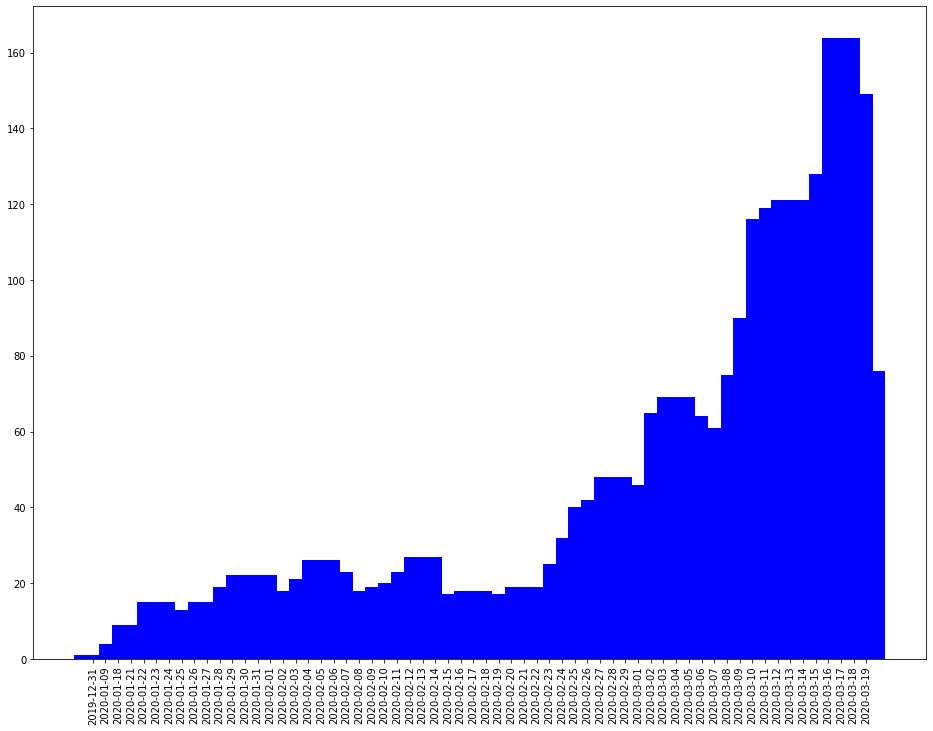

In [11]:
plt.figure(figsize=(16, 12))
plt.xticks(rotation=90)
plt.bar(list(date_frequencies.keys()), list(date_frequencies.values()), 3, color='b')

# plt.figure(figsize=(10, 10))

In [18]:
   
    
fetch_url = f'http://content.guardianapis.com/tags?q=coronavirus&api-key={GUARDIAN_API_KEY}'

r = requests.get(fetch_url).json()
print_json(r)

{
  "response": {
    "status": "ok",
    "userTier": "developer",
    "total": 6,
    "startIndex": 1,
    "pageSize": 10,
    "currentPage": 1,
    "pages": 1,
    "results": [
      {
        "id": "campaign/callout/callout-coronavirus",
        "type": "campaign",
        "webTitle": "callout-coronavirus",
        "webUrl": "https://www.theguardian.com/campaign/callout/callout-coronavirus",
        "apiUrl": "https://content.guardianapis.com/campaign/callout/callout-coronavirus",
        "campaignInformationType": "callout"
      },
      {
        "id": "world/series/coronavirus-live",
        "type": "series",
        "sectionId": "world",
        "sectionName": "World news",
        "webTitle": "Coronavirus live",
        "webUrl": "https://www.theguardian.com/world/series/coronavirus-live",
        "apiUrl": "https://content.guardianapis.com/world/series/coronavirus-live",
        "description": "<p>Follow the Guardian's live coverage of the coronavirus outbreak<br></p>"
      